In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [3]:
dir = "C:\\Code\\pepper-disease\\training\\pepper_images"

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dir,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 2475 files belonging to 2 classes.


In [6]:
CLASS_NAMES = dataset.class_names
CLASS_NAMES

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [7]:
import os
total = 0
for labels in os.listdir(dir):
    counter = 0
    for file in os.listdir(dir+ f"\\{labels}"):
        counter += 1
    total += counter

total

2475

In [8]:
for images_in_batch, labels_in_batch in dataset.take(1):
    print(images_in_batch[0].numpy())
    print(labels_in_batch[0].numpy().astype("uint8"))

[[[134. 116. 114.]
  [213. 195. 193.]
  [174. 156. 154.]
  ...
  [ 97.  85.  85.]
  [135. 123. 123.]
  [112. 100. 100.]]

 [[168. 150. 148.]
  [154. 136. 134.]
  [148. 130. 128.]
  ...
  [142. 130. 130.]
  [102.  90.  90.]
  [132. 120. 120.]]

 [[118. 100.  98.]
  [138. 120. 118.]
  [145. 127. 125.]
  ...
  [129. 117. 117.]
  [133. 121. 121.]
  [101.  89.  89.]]

 ...

 [[155. 141. 141.]
  [167. 153. 153.]
  [154. 140. 140.]
  ...
  [187. 177. 185.]
  [168. 158. 166.]
  [185. 175. 183.]]

 [[158. 144. 144.]
  [179. 165. 165.]
  [165. 151. 151.]
  ...
  [168. 158. 166.]
  [198. 188. 196.]
  [179. 169. 177.]]

 [[152. 138. 138.]
  [181. 167. 167.]
  [167. 153. 153.]
  ...
  [141. 131. 139.]
  [160. 150. 158.]
  [150. 140. 148.]]]
1


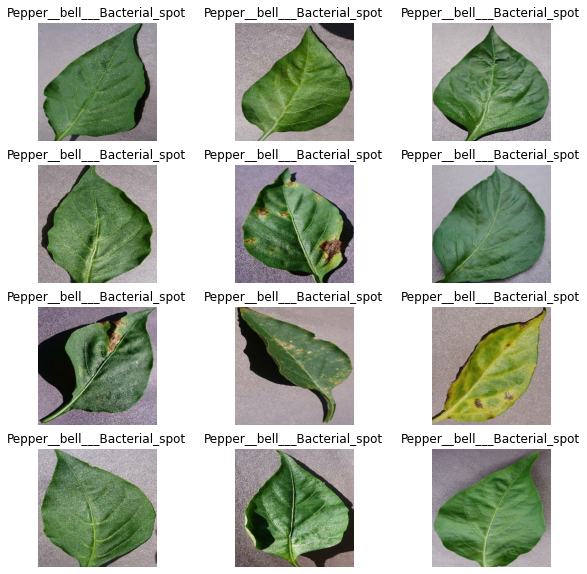

In [9]:
plt.figure(figsize=(10,10))
for images_in_batch, labels_in_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(4,3, i+1)
        plt.imshow(images_in_batch[i].numpy().astype("uint"))
        plt.title(CLASS_NAMES[np.argmax(labels_in_batch[i])])
        plt.axis("off")

In [10]:
def get_dataset_split(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle = True, shuffle_size = 10000):
    
    assert(train_ratio + val_ratio + test_ratio) == 1

    if shuffle == True:
        dataset.shuffle(shuffle_size, seed = 12)
    
    dataset_size = len(dataset) # number of batches

    train_size = int(dataset_size*train_ratio)
    val_size = int(dataset_size*val_ratio)
    test_size = int(dataset_size*test_ratio)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [11]:
train_ds, val_ds, test_ds = get_dataset_split(dataset)

In [12]:
print("len(train_ds): ", len(train_ds))
print("len(val_ds): ", len(val_ds))
print("len(test_ds): ", len(test_ds))

len(train_ds):  62
len(val_ds):  7
len(test_ds):  9


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
BATCH_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # (32,256,256,3)
n_classes = len(CLASS_NAMES) # 10

model = models.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),

    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),

    layers.Conv2D(32, kernel_size = (3,3), activation = "relu", input_shape = BATCH_SHAPE),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = "softmax")
])

In [15]:
model.build(input_shape = BATCH_SHAPE)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (32, 256, 256, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (32, 256, 256, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (32, 256, 256, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        1

In [17]:
model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics = ["accuracy"]
)

In [18]:
model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose = 1,
    validation_data= val_ds,
)

Epoch 1/5
62/62 [==============================] - 222s 3s/step - loss: 0.5332 - accuracy: 0.7233 - val_loss: 0.4473 - val_accuracy: 0.7857
Epoch 2/5
62/62 [==============================] - 202s 3s/step - loss: 0.2558 - accuracy: 0.9073 - val_loss: 0.2114 - val_accuracy: 0.9152
Epoch 3/5
62/62 [==============================] - 201s 3s/step - loss: 0.2063 - accuracy: 0.9355 - val_loss: 0.1980 - val_accuracy: 0.9062
Epoch 4/5
62/62 [==============================] - 205s 3s/step - loss: 0.1505 - accuracy: 0.9667 - val_loss: 0.0645 - val_accuracy: 0.9866
Epoch 5/5
62/62 [==============================] - 206s 3s/step - loss: 0.0803 - accuracy: 0.9814 - val_loss: 0.1000 - val_accuracy: 0.9464


In [19]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 9s 778ms/step - loss: 0.1092 - accuracy: 0.9588


first image to predict
actual label:  Pepper__bell___healthy
predicted label:  Pepper__bell___healthy


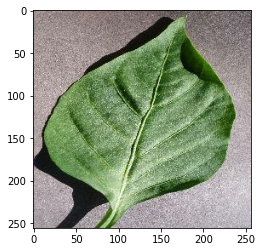

In [20]:
for images_in_batch, labels_in_batch in dataset.take(1):
    first_image = images_in_batch[0].numpy().astype("uint8")
    first_label = labels_in_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", CLASS_NAMES[first_label])

    predictions = model.predict(images_in_batch)
    print("predicted label: ", CLASS_NAMES[np.argmax(predictions[0])])


In [21]:
def my_predict(model, img):
    img_to_array = tf.keras.preprocessing.image.img_to_array(img)
    img_to_array = np.expand_dims(img_to_array, 0)

    predictions = model.predict(img_to_array)

    predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)

    return predicted_class, confidence

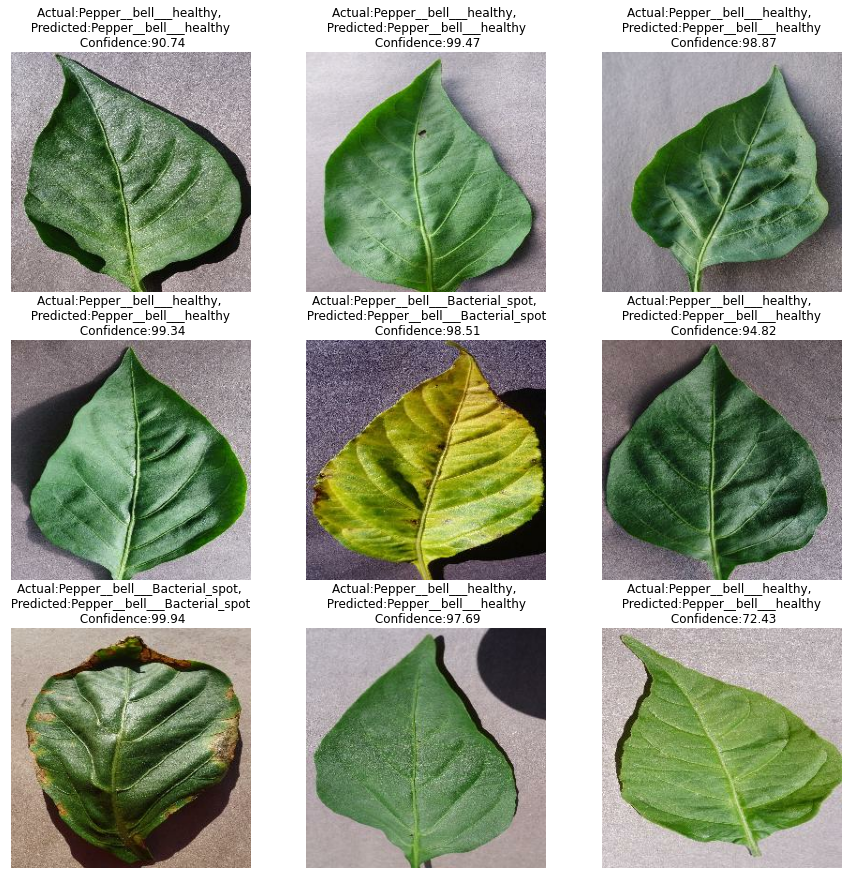

In [24]:
plt.figure(figsize = (15,15))
for images_in_batch, labels_in_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images_in_batch[i].numpy().astype("uint8"))

        predicted_class, confidence = my_predict(model, images_in_batch[i].numpy())
        actual_class = CLASS_NAMES[labels_in_batch[i]]

        plt.title(f"Actual:{actual_class}, \n Predicted:{predicted_class} \n Confidence:{confidence}")
        plt.axis("off")